<a href="https://colab.research.google.com/github/Schwarzam/NN-SPLUS/blob/master/Test_S_E_IRG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [5]:
pip install schzz --upgrade

  Using cached https://files.pythonhosted.org/packages/b6/b5/b6e8f422fce3dfb0cdf0d06f4c8c986a596421d5caa152669395d7d2cdd4/schzz-0.25-py3-none-any.whl
  Found existing installation: schzz 0.3
    Uninstalling schzz-0.3:
      Successfully uninstalled schzz-0.3


In [6]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from skimage.io import imread
from sklearn.model_selection import train_test_split
from schzz import RealTime, Submit
from sklearn.metrics import classification_report, confusion_matrix

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, GlobalAveragePooling2D, BatchNormalization

Download Images

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/trainsets/ALLpngsDifBands.zip \
    -O /tmp/Galaxies.zip

--2020-08-19 21:20:01--  https://storage.googleapis.com/trainsets/ALLpngsDifBands.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 848688951 (809M) [application/zip]
Saving to: ‘/tmp/Galaxies.zip’

/tmp/Galaxies.zip   100%[===================>] 809.37M  73.4MB/s    in 15s     

2020-08-19 21:20:18 (54.1 MB/s) - ‘/tmp/Galaxies.zip’ saved [848688951/848688951]



Extract Imgs, load csv

In [8]:
local_zip = '/tmp/Galaxies.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

base_dir = '/tmp/Galaxies/'

IRG_dir = '/tmp/Galaxies/IRG/'
IGU_dir = '/tmp/Galaxies/IGU/'
ZRG_dir = '/tmp/Galaxies/ZRG/'
R660G_dir = '/tmp/Galaxies/R660G/'

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/Schwarzam/NN-SPLUS/master/ImgsCSV.csv')

In [10]:
df

,Unnamed: 0,FIELD,ID,RA_1,Dec_1,r_petro,zb,zb_Min,zb_Max,PROB_GAL_new,SPIRAL,ELLIPTICAL,UNCERTAIN,simple_class
0,0,STRIPE82-0001,SPLUS.STRIPE82-0001.03217.griz,359.9707,-1.2178,16.50,0.1118,0.083,0.139,1.0,1,0,0,Ec
1,1,STRIPE82-0001,SPLUS.STRIPE82-0001.03462.griz,0.1286,-1.2130,15.80,0.0670,0.061,0.072,1.0,0,0,1,SB
2,2,STRIPE82-0001,SPLUS.STRIPE82-0001.03521.griz,0.0559,-1.2136,16.34,0.0800,0.074,0.079,1.0,1,0,0,SB
3,3,STRIPE82-0001,SPLUS.STRIPE82-0001.03897.griz,0.2156,-1.1983,16.77,0.2070,0.194,0.221,1.0,0,1,0,Er
4,4,STRIPE82-0001,SPLUS.STRIPE82-0001.04092.griz,0.1664,-1.1912,16.88,0.1550,0.081,0.158,1.0,0,0,1,Ei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,8913,STRIPE82-0170,SPLUS.STRIPE82-0170.28231.griz,357.9039,0.8854,15.10,0.0740,0.069,0.076,1.0,0,1,0,Er
8287,8914,STRIPE82-0170,SPLUS.STRIPE82-0170.28516.griz,358.1675,0.8765,16.80,0.1230,0.109,0.123,1.0,0,0,1,Er
8288,8915,STRIPE82-0170,SPLUS.STRIPE82-0170.28780.griz,358.2519,0.8705,16.85,0.1350,0.120,0.140,1.0,0,0,1,Er
8289,8916,STRIPE82-0170,SPLUS.STRIPE82-0170.34215.griz,358.3806,1.2268,15.68,0.0710,0.064,0.083,1.0,1,0,0,S


In [11]:
arr = []

for key, value in df.iterrows():
  if value.SPIRAL == 1:
    arr.append(0)
  if value.ELLIPTICAL == 1:
    arr.append(1)
  if value.UNCERTAIN == 1:
    arr.append(2)

df = df.assign(Class = arr)

In [12]:
df['IRG'] = df['ID'].map(lambda ID: os.path.join(IRG_dir, f'{ID}.png'))
df['IGU'] = df['ID'].map(lambda ID: os.path.join(IGU_dir, f'{ID}.png'))
df['ZRG'] = df['ID'].map(lambda ID: os.path.join(ZRG_dir, f'{ID}.png'))
df['R660G'] = df['ID'].map(lambda ID: os.path.join(R660G_dir, f'{ID}.png'))

in_channel = 3
img_rows, img_cols = 128, 128
num_classes = 3 # number of appliances

input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

batch_size = 10
labels = df['Class'].values
arr_labels = df['Class'].values

labels = keras.utils.to_categorical(labels, 3)

In [13]:
def read_spectograms(file_paths, img_rows, img_cols, channels):
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255.0 #np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [14]:
targets = df[(df['SPIRAL'] == 1) | (df['ELLIPTICAL'] == 1)]
targets['Class'].value_counts()

0    2615
1    1206
Name: Class, dtype: int64

In [15]:
np.random.seed(10)

remove_n = 1300
ellipt = targets[targets['Class'] == 0]
drop_indices = np.random.choice(ellipt.index, remove_n, replace=False)
targets = targets.drop(drop_indices)



labels = targets['Class'].values
arr_labels = targets['Class'].values

targets['Class'].value_counts()

0    1315
1    1206
Name: Class, dtype: int64

In [16]:
x_train_IRG = read_spectograms(targets['IRG'].values, img_rows, img_cols, in_channel)
x_train_IGU = read_spectograms(targets['IGU'].values, img_rows, img_cols, in_channel)
x_train_ZRG = read_spectograms(targets['ZRG'].values, img_rows, img_cols, in_channel)
x_train_R660G = read_spectograms(targets['R660G'].values, img_rows, img_cols, in_channel)

[]

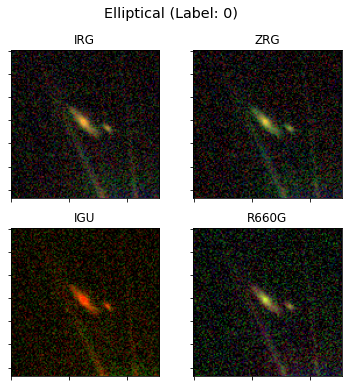

In [17]:
appliances = [
    
    'Elliptical',
    'Spiral',
    
]

rn_appliance = np.random.choice(targets['Class'].values)
rn_label = targets['Class'].values[rn_appliance]
rn_IRG = x_train_IRG[rn_appliance]
rn_IGU = x_train_IGU[rn_appliance]
rn_ZRG = x_train_ZRG[rn_appliance]
rn_R660G = x_train_R660G[rn_appliance]

fig, ax = plt.subplots(2, 2, figsize=((6,6)))
plt.suptitle(f"{appliances[rn_label]} (Label: {rn_label})", fontsize="x-large")

curr_img = None

curr_img = np.reshape(rn_IRG, (img_rows, img_cols, in_channel))

ax[0, 0].imshow(curr_img, cmap='gray')
ax[0, 0].set_title("IRG")
ax[0, 0].plot()

ax[0, 0].set_yticklabels([])
ax[0, 0].set_xticklabels([])

curr_img = np.reshape(rn_ZRG, (img_rows, img_cols, in_channel))

ax[0, 1].imshow(curr_img, cmap='gray')
ax[0, 1].set_title("ZRG")
ax[0, 1].plot()

ax[0, 1].set_yticklabels([])
ax[0, 1].set_xticklabels([])

curr_img = np.reshape(rn_IGU, (img_rows, img_cols, in_channel))

ax[1, 0].imshow(curr_img, cmap='gray')
ax[1, 0].set_title("IGU")
ax[1, 0].plot()

ax[1, 0].set_yticklabels([])
ax[1, 0].set_xticklabels([])

curr_img = np.reshape(rn_R660G, (img_rows, img_cols, in_channel))

ax[1, 1].imshow(curr_img, cmap='gray')
ax[1, 1].set_title("R660G")
ax[1, 1].plot()

ax[1, 1].set_yticklabels([])
ax[1, 1].set_xticklabels([])

In [ ]:
x_train_comp = np.stack((x_train_IRG, x_train_IGU), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)


# take them apart
train_IRG = x_train[:,:,:,:,0]
test_IRG = x_test[:,:,:,:,0]

train_IGU = x_train[:,:,:,:,1]
test_IGU = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_IRG = x_test[:,:,:,:,0]
val_IRG = x_val[:,:,:,:,0]

test_IGU = x_test[:,:,:,:,1]
val_IGU = x_val[:,:,:,:,1]

del x_train_IRG
del x_train_IGU

In [20]:
x_train_comp = np.stack((x_train_ZRG, x_train_R660G), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)

# take them apart
train_ZRG = x_train[:,:,:,:,0]
test_ZRG = x_test[:,:,:,:,0]

train_R660G = x_train[:,:,:,:,1]
test_R660G = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_ZRG = x_test[:,:,:,:,0]
val_ZRG = x_val[:,:,:,:,0]

test_R660G = x_test[:,:,:,:,1]
val_R660G = x_val[:,:,:,:,1]

del x_train_ZRG
del x_train_R660G

CREATING MODEL

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

base_model = InceptionV3(weights='imagenet', include_top=False)
base_model1 = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [21]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(128, (3, 3), padding='same')(model)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(256, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
  model = Conv2D(512, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)

  return model

In [23]:
IRG_input = Input(shape=input_shape)
IRG_model = base_model(IRG_input)
IRG_model = GlobalAveragePooling2D()(IRG_model)

# IGU_input = Input(shape=input_shape)
# IGU_model = create_convolution_layers(IGU_input)
# IGU_model = Flatten()(IGU_model)

# ZRG_input = Input(shape=input_shape)
# ZRG_model = create_convolution_layers(ZRG_input)
# ZRG_model = Flatten()(ZRG_model)

# R660G_input = Input(shape=input_shape)
# R660G_model = create_convolution_layers(R660G_input)
# R660G_model = Flatten()(R660G_model)

# conv = concatenate([IRG_model, IGU_model, ZRG_model, R660G_model])

dense = Dense(4098)(IRG_model)
dense = Dropout(0.3)(dense)
dense = Dense(4098)(dense)
dense = Dropout(0.3)(dense)
dense = Dense(2048)(dense)
dense = Dropout(0.3)(dense)
dense = Dense(512)(dense)
dense = Dense(256)(dense)

output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=IRG_input, outputs=[output])

DATA ARGUMENTATION

In [24]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_multiple_inputs(X1, X2, X3, X4, y, batch_size):
    genX1 = gen.flow(X1,y, batch_size=batch_size,seed=666)
    genX2 = gen.flow(X2,y, batch_size=batch_size,seed=666)
    genX3 = gen.flow(X3,y, batch_size=batch_size,seed=666)
    genX4 = gen.flow(X4,y, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            X4i = genX4.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[0], X3i[0], X4i[0]], X1i[1]

gen_flow = gen_flow_for_multiple_inputs(train_IRG, train_IGU, train_ZRG, train_R660G, y_train, batch_size)

In [25]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

genX1 = gen.flow(train_IRG, y_train,  batch_size=batch_size,seed=666)

In [39]:
epochs = 40

lr = 1e-4
decay_rate = (lr / epochs)
momentum = 0.3


opt = optimizers.SGD(learning_rate=lr, decay=decay_rate, momentum=momentum)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [40]:
history = model.fit(genX1,
                      batch_size=batch_size,
                      epochs=epochs,
                      steps_per_epoch = (len(train_IRG)/batch_size),
                      validation_data=(test_IRG, y_test),
                      verbose=1,
                      callbacks=[RealTime.SendStats('CZz5ifTcDzVlST9')],
                      shuffle=False)

Epoch 1/40
177/176 [==============================] - 12s 65ms/step - loss: 0.2261 - accuracy: 0.9070 - val_loss: 0.1616 - val_accuracy: 0.9369
Epoch 2/40
177/176 [==============================] - 10s 58ms/step - loss: 0.2101 - accuracy: 0.9138 - val_loss: 0.1463 - val_accuracy: 0.9408
Epoch 3/40
177/176 [==============================] - 10s 59ms/step - loss: 0.2415 - accuracy: 0.9014 - val_loss: 0.1709 - val_accuracy: 0.9191
Epoch 4/40
177/176 [==============================] - 10s 58ms/step - loss: 0.2454 - accuracy: 0.9065 - val_loss: 0.1487 - val_accuracy: 0.9428
Epoch 5/40
177/176 [==============================] - 10s 59ms/step - loss: 0.2195 - accuracy: 0.9116 - val_loss: 0.1594 - val_accuracy: 0.9389
Epoch 6/40
177/176 [==============================] - 10s 59ms/step - loss: 0.2225 - accuracy: 0.9087 - val_loss: 0.1486 - val_accuracy: 0.9369
Epoch 7/40
177/176 [==============================] - 10s 59ms/step - loss: 0.2350 - accuracy: 0.9036 - val_loss: 0.1403 - val_accuracy:

In [41]:
resultado = model.evaluate([val_IRG, val_IGU, val_ZRG, val_R660G], y_val)
resultado

8/8 [==============================] - 0s 27ms/step - loss: 0.1375 - accuracy: 0.9480


[0.13748086988925934, 0.9480000138282776]

In [32]:
def reset_series():
  global acc
  global val_acc
  global val_loss
  global loss
  acc = []
  val_acc = []
  loss = []
  val_loss = []

In [33]:
reset_series()

In [34]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [42]:
acc = np.append(acc, history.history['accuracy'])
val_acc = np.append(val_acc,history.history['val_accuracy'])
loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])

epochs = range(1, len(acc)+1)

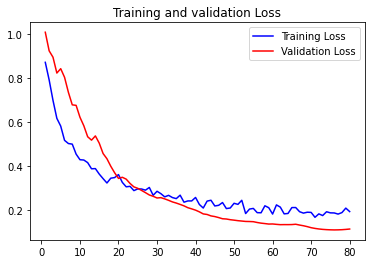

In [43]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

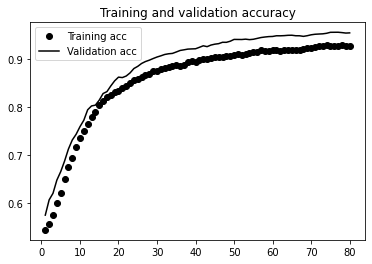

In [44]:
plt.plot(epochs, smooth_curve(acc), 'ko', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [265]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [266]:
import time
from datetime import date

def mark_progress(model , history, acc, val_acc, loss, val_loss):

  tempo = time.strftime("%H,%M")

  hoje = date.today()
  today1 = hoje.strftime("%B %d, %Y")
  today1 = today1.replace(" ", "")

  !mkdir '/content/drive/My Drive/TrainSets/Relatorios/'{today1}
  !mkdir '/content/drive/My Drive/TrainSets/Relatorios/'{today1}'/'{tempo}


  today = [today1 for i in loss]

  epochs = range(1, len(acc)+1)

  plot = plot_model(model, to_file=f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/ModelUsed.jpg",
        show_shapes=True,
        show_layer_names=True,
        rankdir="TB",
        dpi=96,)

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation Loss')
  plt.legend()

  plt.savefig(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Loss.jpg")
  plt.clf()

  plt.plot(epochs, acc, 'ko', label='Training acc')
  plt.plot(epochs, val_acc, 'k', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.savefig(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Validation.jpg")
  plt.clf()

  model.save(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Model")


In [267]:
mark_progress(model, history, acc, val_acc, loss, val_loss)

mkdir: cannot create directory ‘/content/drive/My Drive/TrainSets/Relatorios/August19,2020’: File exists
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/TrainSets/Relatorios/August19,2020/23,49/Model/assets


<Figure size 432x288 with 0 Axes>

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    x = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    return x

Normalized confusion matrix


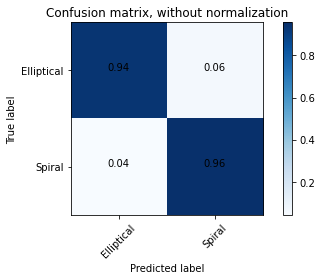

In [241]:
def get_array_labels(array):
  Label_y_pred = []
  for x in array:
    if x == 0:
      Label_y_pred = np.append(Label_y_pred,'Spiral')
    if x == 1:
      Label_y_pred = np.append(Label_y_pred,'Elliptical')

  return Label_y_pred

Y_pred = model.predict(val_IRG)

y_pred = []
for x in Y_pred: 
  if float(x[0]) > 0.50:
    y_pred.append(1)
  if float(x[0]) < 0.50:
    y_pred.append(0)

y_true = ['Elliptical',  'Spiral']


Label_y_pred = get_array_labels(y_pred)
Label_y_true = get_array_labels(val_labels)

cnf_matrix = confusion_matrix(Label_y_pred, Label_y_true, labels=y_true)

zeta = plot_confusion_matrix(cnf_matrix, classes=y_true,
                      title='Confusion matrix, without normalization', normalize=True)

report = classification_report(Label_y_true, Label_y_pred, target_names=y_true)

In [242]:
print(report)

              precision    recall  f1-score   support

  Elliptical       0.94      0.95      0.94       110
      Spiral       0.96      0.95      0.95       140

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250



In [243]:
def get_uncertains(predictions):
  label_pred = []
  for objs in predictions:
    if objs >= 0.25 and objs <= 0.75:
      label_pred.append('Uncertain')
    if objs < 0.25:
      label_pred.append('Spiral')
    if objs > 0.75:
      label_pred.append('Elliptical')
    
  return label_pred

In [244]:
comparison = Label_y_pred == Label_y_true

In [245]:
comparison = np.where(comparison == False)

In [246]:
comparison[0][0]

3

In [247]:
Label_y_pred[1]

'Spiral'

In [248]:
Y_pred[1]

array([2.3993975e-06], dtype=float32)

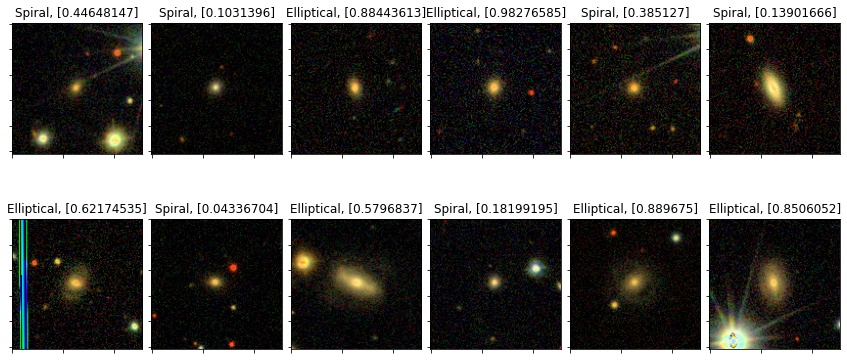

In [271]:
rn_IRG = val_IRG

fig, axs = plt.subplots(2,6, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for key, value in enumerate(comparison[0]):
  try:
    axs[key].imshow(rn_IRG[value])
    axs[key].set_title(f'{Label_y_pred[value]}, {Y_pred[value]}' )
    axs[key].plot()

    axs[key].set_yticklabels([])
    axs[key].set_xticklabels([])
  except:
    pass

fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August19,2020/23,49/missed.jpg')

In [104]:
uncertain = df[df['UNCERTAIN'] == 1][10:20]

uncertain_IRG = read_spectograms(uncertain['IRG'].values, img_rows, img_cols, in_channel)
uncertain_IGU = read_spectograms(uncertain['IGU'].values, img_rows, img_cols, in_channel)
uncertain_ZRG = read_spectograms(uncertain['ZRG'].values, img_rows, img_cols, in_channel)
uncertain_R660G = read_spectograms(uncertain['R660G'].values, img_rows, img_cols, in_channel)

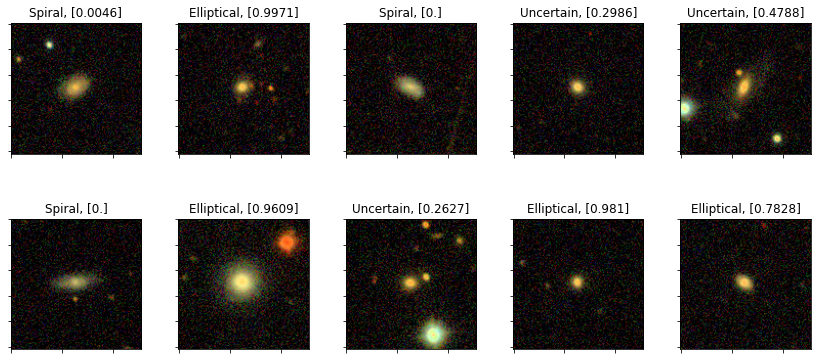

In [273]:
rn_IRG = uncertain_IRG
label_pred = get_uncertains(predictions)

fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for key, value in enumerate(predictions):
  axs[key].imshow(rn_IRG[key], cmap='gray')
  axs[key].set_title(f'{label_pred[key]}, {predictions[key]}' )
  axs[key].plot()

  axs[key].set_yticklabels([])
  axs[key].set_xticklabels([])

fig.savefig('/content/drive/My Drive/TrainSets/Relatorios/August19,2020/23,49/TestOn10Uncertain.jpg')

In [122]:
z = Y_pred[Y_pred > 0.25]
z =  z[z < 0.75]

z

array([0.44648147, 0.66662174, 0.3291954 , 0.31701958, 0.385127  ,
       0.62174535, 0.52321136, 0.63785714, 0.40546253, 0.5796837 ,
       0.44665685, 0.7471856 , 0.4301047 ], dtype=float32)

In [274]:
Submit.make_post('gustavoschwarz', 'asdflkjh', model.to_json(), acc, val_acc, loss, val_loss, '95% Test only IRG inputs S and E', resultado, report)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


400 done
